<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Straight%20From%20Docs/TensorFlow_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun  9 11:22:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Image Segmentation 

Suppose if we want to know where an object is located in the image, the shape of the object, which pixel belongs to which object etc. In this case, we want to segment the image, i.e **each pixel of the image is given a label**. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. 

This helps in understanding the image in the pixel level. The dataset we will be using is the Oxford-IIT Pet Dataset. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. 

Each pixel is given one of the three categories: 
- Case 1: Pixel belonging to the pet. 
- Case 2: Pixel bordering the pet. 
- Case 3: None of the above/Surrounding pixel. 

In [3]:
# Downloading the tensorflow_examples 
!pip install -q git+https://github.com/tensorflow/examples.git

In [5]:
# Importing the things we needed 
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds 
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Download the Oxford-IIIT Pets Dataset 



In [6]:
datasets , info = tfds.load('oxford_iiit_pet:3.*.*' , with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteL63GMI/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteL63GMI/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


The below following code performs a simple augmentations of flipping an image and it's normalized to [0,1]. The pixels in the segmentation masks are labelled either {1, 2, 3} for the sake of convenience let's subtract 1 from the segmentation mask, resulting in labels that are : {0 , 1 ,2}




In [7]:
# Defining the normalizing the function 
def normalize(input_image , input_mask):
  # Converting uint8 to float32 and normalizing it
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image , input_mask

In [19]:
# Funtion to load image and apply some preprocessing (train set)

@tf.function 
def load_image_train(datapoint):
  # Resizingt the image and mask to 128 pixels
  input_image = tf.image.resize(datapoint['image'] , (128 , 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'] , (128 , 128))

  # Randomly flip the image left and right
  if tf.random.uniform(()) > 0.5: 
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  # Applying the normalization function we created just above
  input_image , input_mask = normalize(input_image , input_mask)

  return input_image , input_mask

In [20]:
# Funtion to load image and apply some preprocessing (test set)
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'] , (128 , 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'] , (128 , 128))

  input_image , input_mask = normalize(input_image , input_mask)

  return input_image , input_mask

In [22]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [24]:
# How many splits are there?
info.splits

{'test': <tfds.core.SplitInfo num_examples=3669>,
 'train': <tfds.core.SplitInfo num_examples=3680>}

In [28]:
# Setting up some hyperparameters for our model 

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Now splitting train and test into two variables and apply preprocessing methods on it. 

In [30]:
train = datasets['train'].map(load_image_train , num_parallel_calls = tf.data.AUTOTUNE)
test = datasets['test'].map(load_image_test)

train , test

(<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>)

Inside the dataset 
- (128, 128, 3): This will be our image
- (128, 128, 1): Mask of the image

In [31]:
# Applying prefetch and performance optimization methods on our data 
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

train_dataset , test_dataset

(<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>)

Let's take a look at an image example and it's correponding mask from the dataset.

In [39]:
def display(display_list):
  plt.figure(figsize = (15 , 15))

  title = ['Input Image' , 'True Mask' , 'Predicted Mask']

  for i in range(len(display_list)):
    #print(display_list)
    plt.subplot(1 , len(display_list) , i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis(False)
  plt.show

In [42]:
for image , mask in train.take(3):
  sample_image , sample_mask = image , mask

sample_mask

<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)>

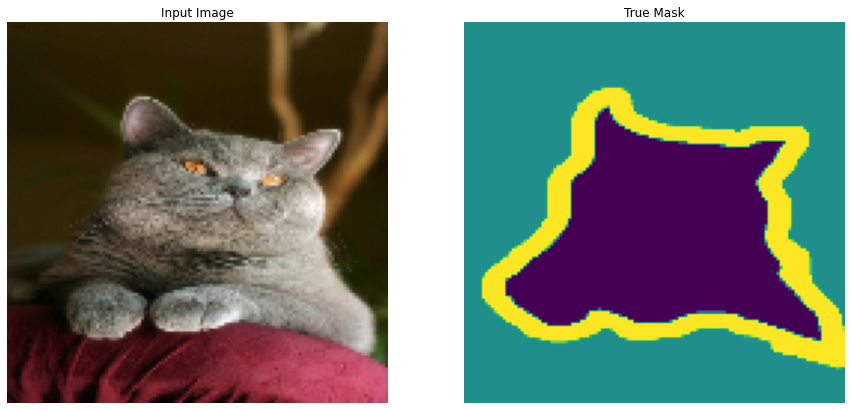

In [43]:
# Using the display function to plot both the input and masked image 
display([sample_image , sample_mask])